Creating a custom dataset for our problem statement

In [4]:
#!pip install albumentations

In [5]:
import joblib
import pandas as pd
from PIL import Image
import albumentations
import numpy as np
import os

In [6]:
import torch
import matplotlib.pyplot as plt

In [7]:
os.chdir("/home/ubuntu/codebase/my_github/kaggle-competitions/bengali-ai/approach_3/src/")

In [8]:
class BengaliDatasetTrain:
    # folds with have multile values for train, one value for valid
    def __init__(self, folds, img_height, img_width, mean, std):
        df = pd.read_csv("../input/train_folds.csv")
        df = df[["image_id","grapheme_root","vowel_diacritic","consonant_diacritic", "kfold"]]
        
        # Let'd filter rows based on kfold
        df = df[df.kfold.isin(folds)].reset_index(drop=True)
        self.image_ids = df.image_id.values
        self.grapheme_root = df.grapheme_root.values
        self.vowel_diacritic = df.vowel_diacritic.values
        self.consonant_diacritic = df.consonant_diacritic.values
        
        # We don't want tranforms (other than basic resize and normalize) on validation set
        if len(folds) == 1:
            self.aug = albumentations.Compose([
                # Resize based on input
                albumentations.Resize(img_height, img_width, always_apply=True),
                # Normalize
                albumentations.Normalize(mean, std, always_apply=True)
                
            ])
        else:
            self.aug = albumentations.Compose([
                # Resize based on input
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.ShiftScaleRotate(shift_limit=0.0625,
                                                scale_limit=0.1,
                                                rotate_limit=5,
                                                p=0.9),# apply 90% of the times
                # Normalize
                albumentations.Normalize(mean, std, always_apply=True)                
            ])
            
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = joblib.load(f"../input/images_pickles/{self.image_ids[item]}.pkl")
        # let's reshape nparray to the given size
        image = image.reshape(137, 236).astype(float)
        # nparray to PIL image
        image = Image.fromarray(image).convert("RGB")
        # Let's apply the transforms defined in init
        image = self.aug(image=np.array(image))["image"]
        # Transpose the image to fit torch vision channels, so exchange channel locations
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return{
            'image': torch.tensor(image, dtype=torch.float),
            'grapheme_root': torch.tensor(self.grapheme_root[item], dtype=torch.long),
            'vowel_diacritic': torch.tensor(self.vowel_diacritic[item], dtype=torch.long),
            'consonant_diacritic': torch.tensor(self.consonant_diacritic[item], dtype=torch.long)
        }

In [9]:
dataset = BengaliDatasetTrain(folds=[0,1], img_height=137, img_width=236,
                             mean=(0.486, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))

In [10]:
len(dataset)

80336

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(38)
tensor(8)
tensor(0)


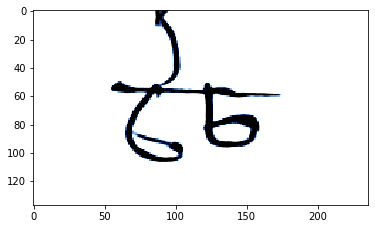

In [12]:
idx = 0
img = dataset[idx]["image"]
print(dataset[idx]["grapheme_root"])
print(dataset[idx]["vowel_diacritic"])
print(dataset[idx]["consonant_diacritic"])
# then convert to npimage
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [11]:
os. getcwd() 

'/home/ubuntu/codebase/my_github/kaggle-competitions/bengali-ai/approach_3/src'